## Import dependencies and load data

In [1]:
import pandas as pd
import numpy as np
import sklearn
import random

np.random.seed(123)
random.seed(123)

In [2]:
train = pd.read_csv('C:/Users/user/Documents/coding/titanic/train.csv')
test = pd.read_csv('C:/Users/user/Documents/coding/titanic/test.csv')

## Exploring the data

In [3]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<AxesSubplot:xlabel='Pclass'>

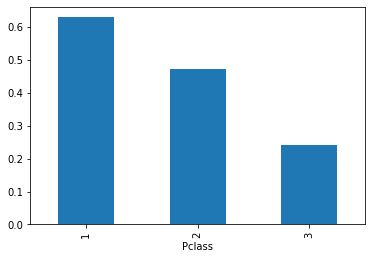

In [4]:
def plotaggs(df): return df.Survived.apply(lambda x: x.sum()/x.count()).plot.bar()

plotaggs(train.groupby(train.Pclass))

<AxesSubplot:xlabel='Sex'>

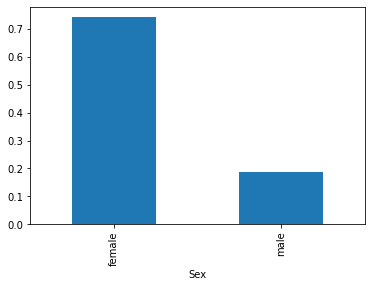

In [5]:
plotaggs(train.groupby(train.Sex))

<AxesSubplot:xlabel='Embarked'>

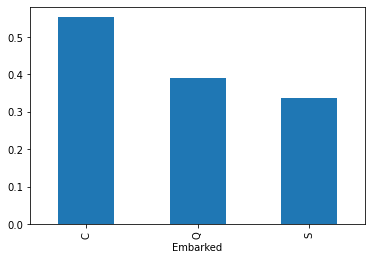

In [6]:
plotaggs(train.groupby(train.Embarked))

## Preprocessing

In [7]:
from sklearn.preprocessing import scale, minmax_scale

def process(df):
    # Set index
    df = df.set_index('PassengerId')
    
    # Clip age
    df.loc[df.Age<1,'Age']=1
    
    # Drop isolated nulls in train set
    df = df.drop(df.loc[df.Embarked.isnull()].index)
    
    # Feature engineering:
    df['mastermiss'] = df.Name.str.extract(r'(Master|Miss)') # extract master/miss - relevant to age
    df['sharedticket'] = df.Ticket.duplicated(keep=False)
    df['solotrip'] = np.where((df.SibSp==0) & (df.Parch==0) & (df.sharedticket==False),1,0)
    
    # Dummies
    df = pd.get_dummies(df,prefix=['emb','pclass','title'],columns=['Embarked','Pclass','mastermiss'])
    df['isMale'] = np.where(df.Sex=='male',1,0)
    
    # Removing extraenous variables
    df = df.drop(['Name','Sex','Ticket','Cabin','sharedticket'], axis=1)
    
    # Standardise fare, minmax scale for all other numerical variables
    df.Fare = scale(df.Fare).flatten()
    for i in ['Age','SibSp','Parch']:
        df[i] = minmax_scale(df[i])   
    return df

train = process(train)
trainx = train.drop('Survived', axis=1)
trainy = train.Survived

test = process(test)
test.Fare = test.Fare.fillna(method='ffill')

## Impute age variable

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

agedf = trainx.dropna()

rfparam_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)],
               'max_depth': [int(x) for x in np.linspace(3, 9, 4)]}
rf_gscv = GridSearchCV(RandomForestRegressor(max_features='sqrt', random_state=42), rfparam_grid, cv=10,n_jobs=5,scoring='neg_root_mean_squared_error',verbose=1)
rf_gscv.fit(agedf.drop('Age',axis=1), agedf.Age)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=10,
             estimator=RandomForestRegressor(max_features='sqrt',
                                             random_state=42),
             n_jobs=5,
             param_grid={'max_depth': [3, 5, 7, 9],
                         'n_estimators': [100, 325, 550, 775, 1000]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [9]:
rf_gscv.best_score_

-0.13913686126819214

In [10]:
ageimpute = rf_gscv.predict(trainx.loc[trainx.Age.isnull()].drop('Age', axis=1)).flatten()
trainx.loc[trainx.Age.isnull(), 'Age'] = ageimpute

In [11]:
# fit another rf model to prevent data leakage
agedf = test.dropna()
rf_gscv.fit(agedf.drop('Age', axis=1), agedf.Age)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=10,
             estimator=RandomForestRegressor(max_features='sqrt',
                                             random_state=42),
             n_jobs=5,
             param_grid={'max_depth': [3, 5, 7, 9],
                         'n_estimators': [100, 325, 550, 775, 1000]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [12]:
rf_gscv.best_score_

-0.14208128923705526

In [13]:
ageimpute = rf_gscv.predict(test.loc[test.Age.isnull()].drop('Age',axis=1)).flatten()
test.loc[test.Age.isnull(), 'Age'] = ageimpute

In [14]:
# Final look at the train and test sets:
trainx.head(3)

,Age,SibSp,Parch,Fare,solotrip,emb_C,emb_Q,emb_S,pclass_1,pclass_2,pclass_3,title_Master,title_Miss,isMale
PassengerId,,,,,,,,,,,,,,
1,0.265823,0.125,0.0,-0.500240,0,0,0,1,0,0,1,0,0,1
2,0.468354,0.125,0.0,0.788947,0,1,0,0,1,0,0,0,0,0
3,0.316456,0.000,0.0,-0.486650,1,0,0,1,0,0,1,0,1,0


In [15]:
test.head(3)

,Age,SibSp,Parch,Fare,solotrip,emb_C,emb_Q,emb_S,pclass_1,pclass_2,pclass_3,title_Master,title_Miss,isMale
PassengerId,,,,,,,,,,,,,,
892,0.446667,0.000,0.0,-0.497811,1,0,1,0,0,0,1,0,0,1
893,0.613333,0.125,0.0,-0.512660,0,0,0,1,0,0,1,0,0,0
894,0.813333,0.000,0.0,-0.464532,1,0,1,0,0,1,0,0,0,1


## Fitting models

In [16]:
from sklearn import model_selection
trainx, validx, trainy, validy = model_selection.train_test_split(trainx,trainy,test_size=0.15,random_state=1)

INFO:tensorflow:Oracle triggered exit
Epoch 1/50
24/24 [==============================] - 1s 9ms/step - loss: 0.6024 - acc: 0.6623 - ce: 0.6024 - val_loss: 0.5655 - val_acc: 0.6493 - val_ce: 0.5655
Epoch 2/50
24/24 [==============================] - 0s 2ms/step - loss: 0.5047 - acc: 0.7351 - ce: 0.5047 - val_loss: 0.5156 - val_acc: 0.7239 - val_ce: 0.5156
Epoch 3/50
24/24 [==============================] - 0s 2ms/step - loss: 0.4808 - acc: 0.7788 - ce: 0.4808 - val_loss: 0.4908 - val_acc: 0.7388 - val_ce: 0.4908
Epoch 4/50
24/24 [==============================] - 0s 2ms/step - loss: 0.4636 - acc: 0.8000 - ce: 0.4636 - val_loss: 0.4806 - val_acc: 0.7537 - val_ce: 0.4806
Epoch 5/50
24/24 [==============================] - 0s 2ms/step - loss: 0.4516 - acc: 0.8026 - ce: 0.4516 - val_loss: 0.4669 - val_acc: 0.7761 - val_ce: 0.4669
Epoch 6/50
24/24 [==============================] - 0s 2ms/step - loss: 0.4431 - acc: 0.8199 - ce: 0.4431 - val_loss: 0.4573 - val_acc: 0.7687 - val_ce: 0.4573
Ep

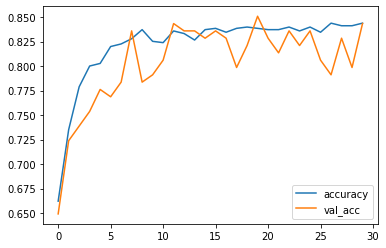

In [18]:
# ANN
from tensorflow import random
from tensorflow import keras
from keras import layers
import keras_tuner as kt

random.set_seed(1234)

def model_builder(hp):
    model = keras.Sequential()
    
    hp_units = hp.Int('units', min_value=2, max_value=14, step=1)
    model.add(layers.Dense(units=hp_units, activation='elu', input_shape=[14]))
    # Output layer    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['acc','ce'])
    return model

stop_early = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.001, patience=10)
tuner = kt.Hyperband(model_builder,objective='val_acc', max_epochs=10, factor=3, overwrite=True)
tuner.search(trainx.to_numpy(), trainy.to_numpy(), epochs=50, validation_split=0.3, callbacks=[stop_early], verbose=0)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

annmodel = tuner.hypermodel.build(best_hps)
hist = annmodel.fit(trainx.to_numpy(), trainy.to_numpy(), 
                    validation_data=(validx.to_numpy(), validy.to_numpy()), 
                    epochs=50, 
                    callbacks=[stop_early])
histdf = pd.DataFrame({'accuracy':hist.history['acc'], 'val_acc':hist.history['val_acc']}).plot()

In [19]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
knnparam_grid = {'n_neighbors': np.arange(1, 50)}
knn_gscv = GridSearchCV(KNeighborsClassifier(), knnparam_grid, cv=10, scoring='accuracy')
knn_gscv.fit(trainx,trainy)
knn_gscv.best_score_

0.8251578947368421

In [20]:
# RF
from sklearn.ensemble import RandomForestClassifier
rf_gscv = GridSearchCV(RandomForestClassifier(max_features='sqrt'), rfparam_grid, cv=10,n_jobs=5,scoring='accuracy')
rf_gscv.fit(trainx,trainy)
rf_gscv.best_score_

0.8383684210526315

In [21]:
# Adaboost
from sklearn.ensemble import AdaBoostClassifier
adaparam_grid = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
                 'learning_rate': [0.005,0.01]}
ada_gscv = GridSearchCV(AdaBoostClassifier(), adaparam_grid, cv=10, n_jobs=8, scoring='accuracy')
ada_gscv.fit(trainx, trainy)
ada_gscv.best_score_

0.8172456140350877

In [22]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(solver='liblinear', fit_intercept=False)
logmodel.fit(trainx, trainy)

LogisticRegression(fit_intercept=False, solver='liblinear')

## Results

In [26]:
results = pd.DataFrame(
    [[hist.history['val_acc'][-1],np.round(annmodel.predict(validx).flatten()),np.round(annmodel.predict(test).flatten())],
     [knn_gscv.score(validx,validy),knn_gscv.predict(validx),knn_gscv.predict(test)],
     [rf_gscv.score(validx,validy),rf_gscv.predict(validx),rf_gscv.predict(test)],
     [ada_gscv.score(validx,validy),ada_gscv.predict(validx),ada_gscv.predict(test)],
     [logmodel.score(validx,validy),logmodel.predict(validx),logmodel.predict(test)]],
    columns=['val_score','val_pred','test_pred'],
    index=['ann','knn','rf','ada','logreg']
    )
print(results['val_score'].sort_values())

14/14 [==============================] - 0s 616us/step
knn       0.805970
rf        0.805970
ada       0.843284
ann       0.843284
logreg    0.850746
Name: val_score, dtype: float64


Adding a combined model classifier: predictions are weighted by accuracy score, divided by sum of all accuracy scores, and rounded to 0, 1

In [24]:
weighted_pred = ((results.val_pred * results.val_score).sum()/(results.val_score.sum())).round()
wpred_val = sklearn.metrics.accuracy_score(validy, weighted_pred)
wpred_test = ((results.test_pred * results.val_score).sum()/(results.val_score.sum())).round()
print(f'Weighted prediction validation score: {wpred_val}')

Weighted prediction validation score: 0.8507462686567164


The weighted prediction is a top performer. Now let's check out the performance of each model on Kaggle's private Titanic test set.

## Performance on Kaggle's private test set:
- score for the KNN model: 0.73205
- score for the Adaboost model: 0.76794
- score for the Logistic Regression model: 0.77033
- score for the ANN model: 0.77272
- score for the weighted combined model: 0.77272
- score for the RF model: 0.78229 (best!)

Surprisingly, the RF model managed to outperform all the other models despite performing slightly worse on the validation set. Meanwhile, the logistic regression and Adaboost model seemed to suffer from overfitting, which led to a decrease in performance on the hidden test set, relative to other models.

Possible enhancements would involve more feature engineering. Extracting information from cabin number might have potential, and domain knowledge on tickets or fare calculation might glean additional information. The 'Fare' predictor could've been clipped at high values as well, although I made the decision to preserve those values. 